### FIGURE 2

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import MSclusPLSR_tuning
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.figures.figure3 import plotR2YQ2Y, plotMeasuredVsPredicted, plotScoresLoadings, plotclusteraverages
from msresist.clustering import MassSpecClustering
from msresist.sequence_analysis import preprocess_seqs, FormatName, pYmotifs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing, MergeDfbyMean, LinearFoldChange, FoldChangeToControl, MapOverlappingPeptides, BuildMatrix, TripsMeanAndStd, CorrCoefFilter
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

In [2]:
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_columns', 1000)

### Importing and Pre-processing Data

### Phosphorylation measurements:

In [3]:
ABC = preprocessing(AXLwt=True, Vfilter=True, FCfilter=True, log2T=False, FCtoUT=True, mc_row=True)
ABC = preprocess_seqs(ABC, "Y").sort_values(by="Protein")

header = ABC.columns
treatments = ABC.columns[7:]

data = ABC.select_dtypes(include=['float64']).T
info = ABC.select_dtypes(include=['object'])

0/1493 peptides were not found in the proteome.
1493


In [4]:
ABC.head()

,Protein,Sequence,UniprotAcc,Position,BioReps,r2_Std,Gene,PC9,Erl,R428,Erl/R428,Erl+HGF,Erl+FGF,Erl+IGF,KO Erl,KO R428,KO Erl/R428
0,"1-phosphatidylinositol 4,5-bisphosphate phosph...",RNPGFyVEANP,P19174,Y783-p,1,N/A,PLCG1,1.0,0.491785,0.766856,0.399749,0.535976,0.681548,0.386105,0.328710,0.787673,0.376014
2,"10 kDa heat shock protein, mitochondrial",VLLPEyGGTKV,P61604,Y76-p,1,N/A,HSPE1,1.0,0.850851,0.952355,0.729330,0.765147,0.941005,0.786697,0.972121,1.075515,1.108384
3,14-3-3 protein epsilon,GDYHRyLAEFA,P62258,Y131-p,1,N/A,YWHAE,1.0,1.154295,0.958756,0.613405,0.817597,0.872520,0.843452,0.500112,0.570839,0.488875
4,14-3-3 protein zeta/delta,LLSVAyKNVVG,P63104,Y48-p,1,N/A,YWHAZ,1.0,0.753478,0.604044,0.165229,0.149529,0.147568,0.141626,0.144489,0.164610,0.139950
6,26S proteasome non-ATPase regulatory subunit 12,TEGKIyVEIER,O00232,Y137-p,1,N/A,PSMD12,1.0,0.713752,0.744459,0.640981,0.797963,0.814502,0.751207,0.624134,0.769242,0.788452


### Phenotypes

#### Cell Viability:

In [5]:
Y_cv1 = pd.read_csv('./msresist/data/Phenotypic_data/GrowthFactors/CV_raw3.csv').iloc[:30, :11]
Y_cv2 = pd.read_csv('./msresist/data/Phenotypic_data/GrowthFactors/CV_raw4.csv').iloc[:29, :11]

for ii in range(1, Y_cv2.columns.size):
    Y_cv1.iloc[:, ii] /= Y_cv1.iloc[0, ii]
    Y_cv2.iloc[:, ii] /= Y_cv2.iloc[0, ii]

Y_cv = MergeDfbyMean(pd.concat([Y_cv1, Y_cv2], axis=0), Y_cv1.columns, "Elapsed")
Y_cv = Y_cv.reset_index()[Y_cv1.columns]
Y_cv = Y_cv[Y_cv["Elapsed"] == 72].iloc[0, 1:]

In [6]:
Y_cv

PC9     16.785364
E        5.789075
R        6.217480
ER       3.142243
EHGF     9.506919
EFGF    12.928250
EIGF     6.854597
KOE      3.957291
KOR      5.527921
KOER     2.692503
Name: 24, dtype: float64

# Chained MS mixed clustering + PLSR analysis

TypeError: plotR2YQ2Y() missing 2 required positional arguments: 'Y' and 'cv'

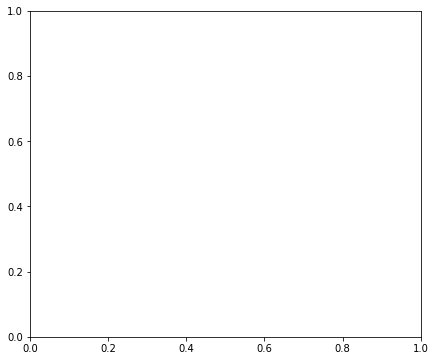

In [7]:
distance_method = "PAM250"
ncl = 2
GMMweight = 0.25

MSC = MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method=distance_method).fit(data, Y_cv)
centers = MSC.transform(data)

fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotR2YQ2Y(ax, centers, Y_cv)

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(8,6))
# plotMixedClusteringPLSR_GridSearch(ax, data, info, Y_cv, distance_method)

In [ ]:
ncomp = 2

mixedCl_plsr = Pipeline([('mixedCl', MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method=distance_method)), ('plsr', PLSRegression(ncomp))])
fit = mixedCl_plsr.fit(data, Y_cv)
centers = mixedCl_plsr.named_steps.mixedCl.transform(data)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plotMeasuredVsPredicted(ax, mixedCl_plsr, data, Y_cv)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
plotScoresLoadings(ax, fit, centers, Y_cv, ncl, treatments)

In [ ]:
clustermembers = mixedCl_plsr.named_steps.mixedCl.clustermembers(ABC.T)
# clustermembers

In [ ]:
create_download_link(clustermembers, "DataClustering")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plotclusteraverages(ax, centers.T, treatments)